# News Summarization

In [1]:
!pip install --quiet transformers
!pip install --quiet pytorch_lightning

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import  (
    AdamW,
    T5TokenizerFast as T5Tokenizer, 
    T5ForConditionalGeneration as T5)

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
pl.seed_everything(42)

INFO:lightning_lite.utilities.seed:Global seed set to 42


42

Download the News Summary Data

In [4]:
!gdown --id 1yRrwVi1d2fJiy5XS_iNSMmKkzJ101Gq_
!mkdir data
!mv news_summary.csv data/

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1yRrwVi1d2fJiy5XS_iNSMmKkzJ101Gq_
To: /content/news_summary.csv
100% 11.9M/11.9M [00:00<00:00, 127MB/s]
mkdir: cannot create directory ‘data’: File exists


In [5]:
df = pd.read_csv('data/news_summary.csv', encoding='latin-1')

In [6]:
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
df = df[['text', 'ctext']]
print(df.shape)
df.columns = ['summary', 'text']
df = df.dropna().reset_index(drop=True)
df.shape

(4514, 2)


(4396, 2)

In [8]:
df.text.apply(str).apply(lambda x: x.split()).apply(len).value_counts()[:10]

266    24
226    21
446    19
280    18
176    18
287    17
207    17
189    17
372    17
215    16
Name: text, dtype: int64

In [9]:
df['text_len'] = df.text.apply(str).apply(lambda x: x.split()).apply(len)
df['summary_len'] = df.summary.apply(str).apply(lambda x: x.split()).apply(len)

In [10]:
df.shape

(4396, 4)

In [11]:
df.drop(df[df['text_len'] < df['summary_len']].index, inplace=True)
df.reset_index(drop=True, inplace=True)
f"{df.shape[0]:,}"

'4,274'

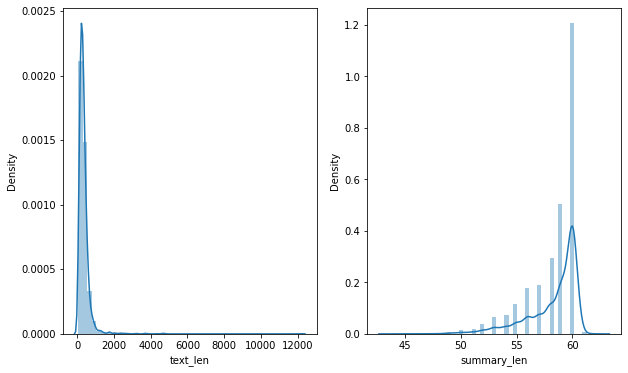

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
sns.distplot(df['text_len'], ax= ax1)
sns.distplot(df['summary_len'], ax= ax2)
plt.show()

In [13]:
df['text_len'].describe()

count     4274.000000
mean       351.740056
std        358.884472
min         50.000000
25%        193.000000
50%        288.000000
75%        416.000000
max      12202.000000
Name: text_len, dtype: float64

In [14]:
df['summary_len'].describe()

count    4274.000000
mean       58.299719
std         2.314246
min        44.000000
25%        57.000000
50%        59.000000
75%        60.000000
max        62.000000
Name: summary_len, dtype: float64

In [15]:
if torch.cuda.is_available():
    print(f"GPU:{torch.cuda.get_device_name()}")
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    print(DEVICE)

GPU:Tesla T4


### Constant

In [16]:
class CONFIG:
  EPOCHS = 3
  NUM_WORKERS = 2
  BATCH_SIZE = 8
  LR = 2e-5
  # Input & Output Sizes (Truncation while tokenization)
  # As T5 takes by max
  MAX_LEN_TEXT = 512
  MAX_LEN_SMRY = 128

  MODEL_NAME = 't5-base'
  tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
  model = T5.from_pretrained(MODEL_NAME)
  criterion = nn.CrossEntropyLoss().to(DEVICE)

In [17]:
CONFIG.tokenizer.max_len_single_sentence, CONFIG.tokenizer.max_model_input_sizes

(511,
 {'t5-small': 512,
  't5-base': 512,
  't5-large': 512,
  't5-3b': 512,
  't5-11b': 512})

In [18]:
CONFIG.tokenizer.model_input_names, CONFIG.tokenizer.vocab_size

(['input_ids', 'attention_mask'], 32100)

In [19]:
df.head()

,summary,text,text_len,summary_len
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...,364,60
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo...",396,60
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...,335,60
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,404,60
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...,526,60


### Dataset

In [23]:
class NewsDataset(Dataset):

  def __init__(self,
               df: pd.DataFrame,
               tokenizer: T5Tokenizer,
               text_max_len: int,
               summary_max_len: int,
               ) -> None:
      super().__init__()

      self.df = df
      self.tokenizer = tokenizer
      self.text_max_len = text_max_len
      self.summary_max_len = summary_max_len
  
  def __len__(self):
    return len(df)

  def __getitem__(self, index):
      row = df.iloc[index]
      text = row['text']
      summary = row['summary']

      text_encoding = self.tokenizer.encode_plus(
          text,
          max_length= self.text_max_len,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors= 'pt'
          )
      
      summary_encoding = self.tokenizer.encode_plus(
          summary,
          max_length= self.summary_max_len,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors= 'pt'
          )
      # update labels as T5 expects -100 for padding indexes not 0
      labels = torch.where(
          summary_encoding['input_ids'].flatten() == 0, 
          -100, 
          summary_encoding['input_ids'].flatten()
          )

      return dict(
          text_input_ids = text_encoding['input_ids'].flatten(),
          labels = labels,
          text_attention_mask = text_encoding['attention_mask'].flatten(),
          summary_attention_mask = summary_encoding['attention_mask'].flatten(),
      )

In [24]:
class NewsDataModule(pl.LightningDataModule):

  def __init__(self,
               train_df: pd.DataFrame,
               test_df: pd.DataFrame,
               batch_size: int,
               tokenizer: T5Tokenizer,
               text_max_len: int,
               summary_max_len: int,
               ) -> None:
      super().__init__()

      self.train_df = train_df
      self.test_df = test_df
      self.tokenizer = tokenizer
      self.batch_size = batch_size
      self.text_max_len = text_max_len
      self.summary_max_len = summary_max_len
  
  def setup(self, stage=None):
    self.train_dataset = NewsDataset(self.train_df, self.tokenizer, self.text_max_len, self.summary_max_len)
    self.test_dataset = NewsDataset(self.test_df, self.tokenizer, self.text_max_len, self.summary_max_len)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
  def val_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True)
  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True)


In [25]:
class NewsModel(pl.LightningModule):

  def __init__(self, model: T5, lr: float) -> None:
      super().__init__()
      self.model = model
      self.lr = lr

  def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
    output = self.model(
        input_ids,
        attention_mask= attention_mask,
        labels = labels,
        decoder_attention_mask = decoder_attention_mask  
    )
    return output.loss, output.logits

  def temp_step(self, batch):

    input_ids = batch['text_input_ids']
    labels = batch['labels']
    attention_mask = batch['text_attention_mask']
    decoder_attention_mask = batch['summary_attention_mask']
    loss, preds = self(
        input_ids = input_ids,
        attention_mask = attention_mask,
        labels = labels,
        decoder_attention_mask = decoder_attention_mask
        )
    return loss

  def training_step(self, batch, batch_idx):
    loss = self.temp_step(batch)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.temp_step(batch)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    loss = self.temp_step(batch)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):
      return AdamW(self.parameters(), lr= self.lr)

In [26]:
logger = TensorBoardLogger("lightning_logs", name='news-summary')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [34]:
train_df, test_df = train_test_split(df, test_size=0.2)

news_dm = NewsDataModule(train_df= train_df,
                         test_df= test_df, 
                         tokenizer= CONFIG.tokenizer, 
                         batch_size=CONFIG.BATCH_SIZE, 
                         text_max_len=CONFIG.MAX_LEN_TEXT, 
                         summary_max_len=CONFIG.MAX_LEN_SMRY)

news_model = NewsModel(CONFIG.model, CONFIG.LR)

In [35]:
train_df.shape, test_df.shape

((3419, 4), (855, 4))

In [36]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

In [37]:
CONFIG.EPOCHS = 1 # For testing the cycle

In [38]:
trainer = pl.Trainer(
    logger=logger,
    callbacks = checkpoint_callback,
    max_epochs=CONFIG.EPOCHS,
    enable_progress_bar=True,
    gpus=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [39]:
trainer.fit(news_model, news_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 535: 'val_loss' reached 1.41890 (best 1.41890), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Load Best model From Checkpoint

In [42]:
summarizer = NewsModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path,
                                            model= CONFIG.model,
                                            lr = CONFIG.LR)

In [49]:
def summarize(text_ex, summarizer=summarizer):
  
  text_ex_token = CONFIG.tokenizer(
                                  text_ex,
                                  max_length= 200,
                                  padding='max_length',
                                  truncation=True,
                                  return_attention_mask=True,
                                  return_tensors= 'pt'
                                  )
  summary_tokens = summarizer.model.generate(**text_ex_token, 
                                            num_beams=5,
                                            repetition_penalty=2.,
                                            length_penalty= 1,
                                            early_stopping=True)
  preds = [CONFIG.tokenizer.decode(s_tkn, 
                                   skip_special_tokens=True, 
                                   clean_up_tokenization_spaces=True) 
          for s_tkn in summary_tokens[0]]

  return " ".join(preds).strip()

In [50]:
text_ex = df['text'][10]
text_ex

'The Food Safety and Standards Authority of India (FSSAI) is in the process of creating a network of food banking partners to collect and distribute leftover food from large parties and weddings to the hungry.A notification to create a separate category of food business operators (FBOs), who will be licensed to deal only with leftover food, has been drafted to ensure the quality of food.?We are looking at partnering with NGOs or organisations that collect, store and distribute surplus food to ensure they maintain certain hygiene and health standards when handling food,? said Pawan Agarwal, CEO of FSSAI.?Tonnes of food is wasted annually. We are looking at creating a mechanism through which food can be collected from restaurants, weddings, large-scale parties,?  says Pawan Agarwal, ?All food, whether it is paid for or distributed free, must meet the country?s food safety and hygiene standards,? he said.The organisations in the business of collecting leftover food will now have to work i

In [51]:
summarize(text_ex)

'The Food Safety and Standards Authority of India ( F SSA I ) is in the process of creating'

### Conclusion

T5 Model is used through such notebook to generate a summarised text given the news text of max length 512 token, and resulting output of 128 token.  
The `summarize` method is used to wrap-up all pre-processing till generation of the summary.  



P.S: *For better results can increase number of epochs*